In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import time

train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_dataset.transform = transform
test_dataset.transform = transform

# Load EMNIST dataset
# train_dataset = datasets.EMNIST('emnist_data', split='letters', train=True, download=True,
#                                 transform=transforms.ToTensor())
# test_dataset = datasets.EMNIST('emnist_data', split='letters', train=False, download=True,
#                                transform=transforms.ToTensor())

m = len(train_dataset)

# random_split randomly split a dataset into non-overlapping new datasets of given lengths
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size = 128

# the dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("Batches in Train Loader: {}".format(len(train_loader)))
print("Batches in Valid Loader: {}".format(len(valid_loader)))
print("Batches in Test Loader: {}".format(len(test_loader)))

print("Examples in Train Loader: {}".format(len(train_loader.sampler)))
print("Examples in Valid Loader: {}".format(len(valid_loader.sampler)))
print("Examples in Test Loader: {}".format(len(test_loader.sampler)))

Batches in Train Loader: 375
Batches in Valid Loader: 94
Batches in Test Loader: 79
Examples in Train Loader: 48000
Examples in Valid Loader: 12000
Examples in Test Loader: 10000


In [3]:
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)  
        
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

In [5]:
history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=15
epochs = []

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0
    model.train()
    start_time = time.time()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()    
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch+1} [{batch_idx*len(images)}/{len(train_loader.sampler)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\tTime: {(time.time()-start_time):.3f} s')

    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in valid_loader:
        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler)*100
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_acc = val_correct / len(valid_loader.sampler) * 100

    # print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs, train_loss, valid_loss, train_acc, valid_acc))
    ep = "Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs, train_loss, valid_loss, train_acc, valid_acc)
    epochs.append(ep)
    history['train_loss'].append(train_loss)    
    history['valid_loss'].append(valid_loss)  
    history['train_acc'].append(train_acc)  
    history['valid_acc'].append(valid_acc)
 
for i in epochs:
    print(i)
# After the training loop
torch.save(model.state_dict(), 'model_weights.pth')

d:\F\Python\Python310\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/48000 (0%)]	Loss: 2.297318	Time: 0.210 s
Train Epoch: 1 [1280/48000 (3%)]	Loss: 1.550485	Time: 2.508 s
Train Epoch: 1 [2560/48000 (5%)]	Loss: 0.736221	Time: 4.201 s
Train Epoch: 1 [3840/48000 (8%)]	Loss: 0.578892	Time: 6.876 s
Train Epoch: 1 [5120/48000 (11%)]	Loss: 0.431102	Time: 9.146 s
Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.281058	Time: 11.327 s
Train Epoch: 1 [7680/48000 (16%)]	Loss: 0.380423	Time: 13.422 s
Train Epoch: 1 [8960/48000 (19%)]	Loss: 0.307419	Time: 15.078 s
Train Epoch: 1 [10240/48000 (21%)]	Loss: 0.274095	Time: 16.725 s
Train Epoch: 1 [11520/48000 (24%)]	Loss: 0.458854	Time: 18.491 s
Train Epoch: 1 [12800/48000 (27%)]	Loss: 0.221274	Time: 20.186 s
Train Epoch: 1 [14080/48000 (29%)]	Loss: 0.268380	Time: 21.844 s
Train Epoch: 1 [15360/48000 (32%)]	Loss: 0.147143	Time: 23.473 s
Train Epoch: 1 [16640/48000 (35%)]	Loss: 0.164887	Time: 25.404 s
Train Epoch: 1 [17920/48000 (37%)]	Loss: 0.173271	Time: 27.027 s
Train Epoch: 1 [19200/48000 (40%)]	Loss: 0.19

In [6]:
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.sampler)

print('Accuracy of the network on the test images: {:.2f} %%'.format(100 * correct / total))
print('Loss of the network on the test images: {:.4f}'.format(test_loss))

Accuracy of the network on the test images: 99.29 %%
Loss of the network on the test images: 0.0237


In [7]:
model_weights = []
conv_layers = []
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)

for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")      

CONV: Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([16, 1, 5, 5])
CONV: Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([32, 16, 5, 5])


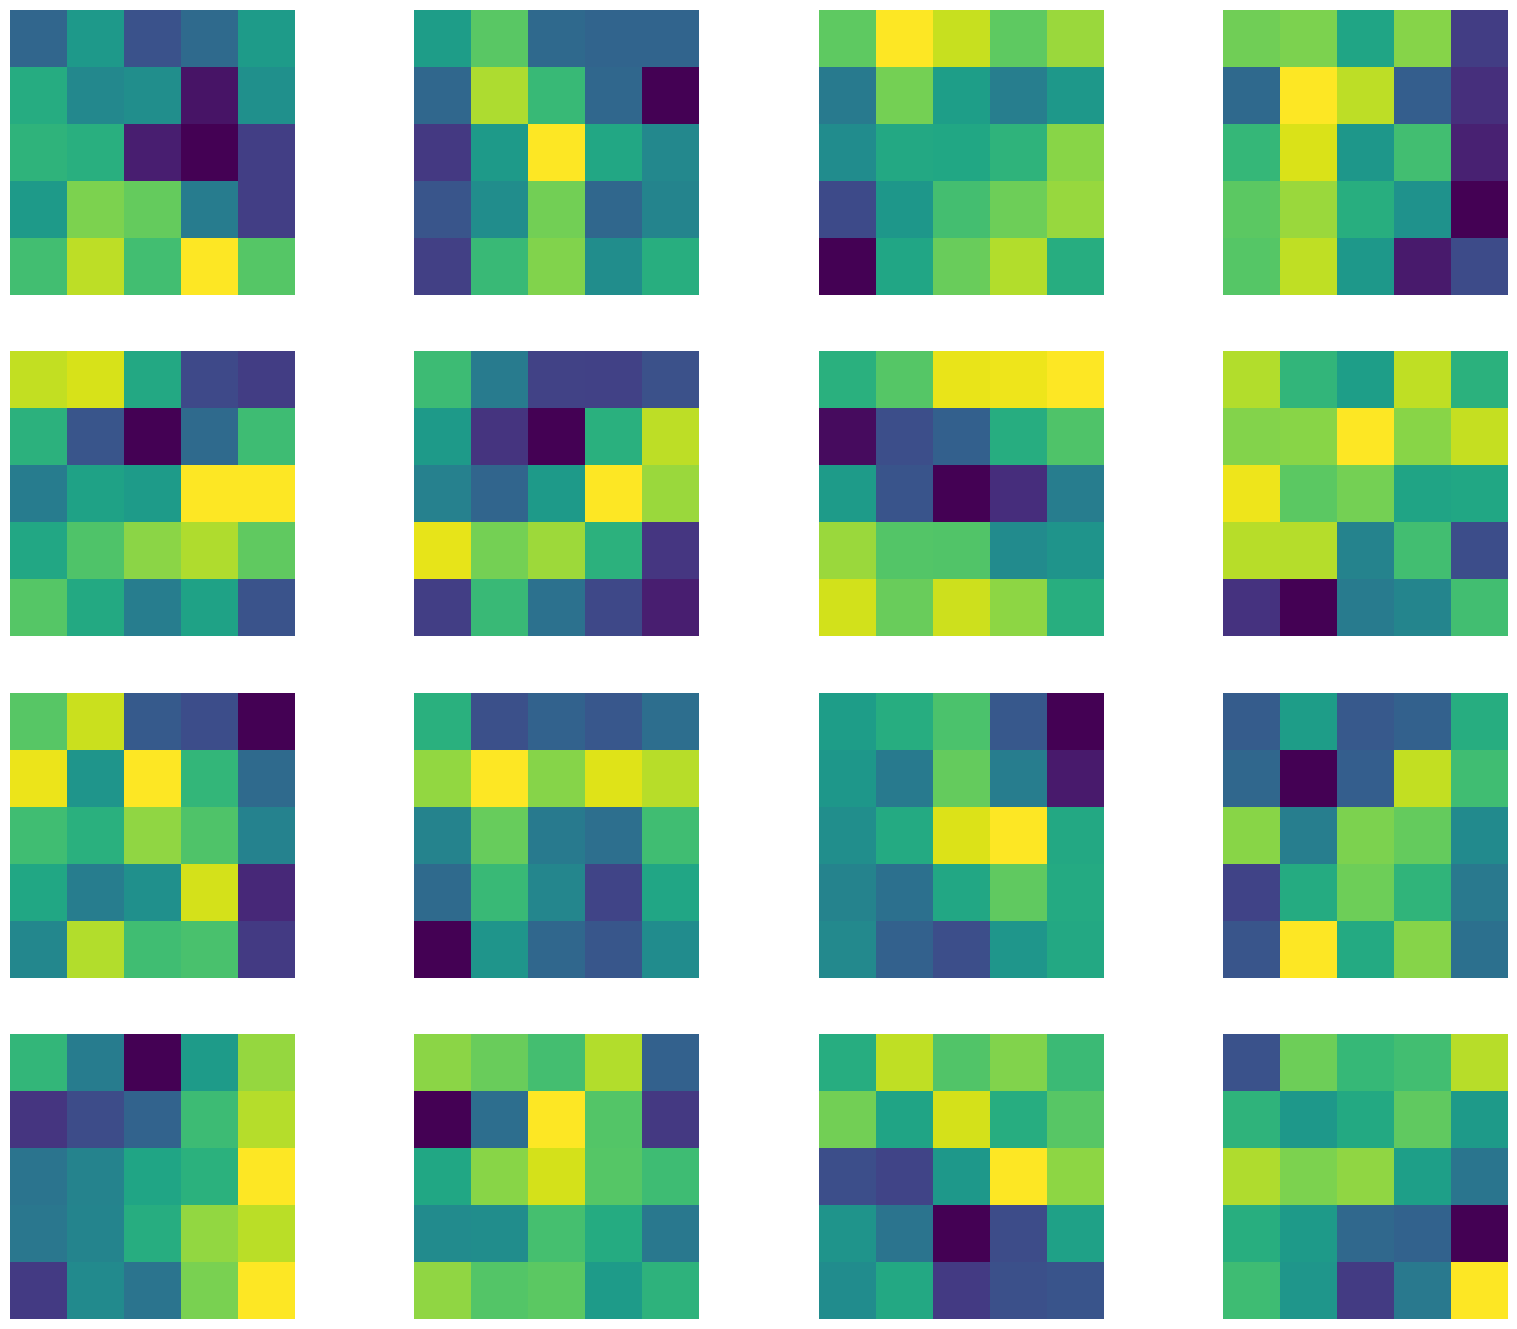

In [8]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 4, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

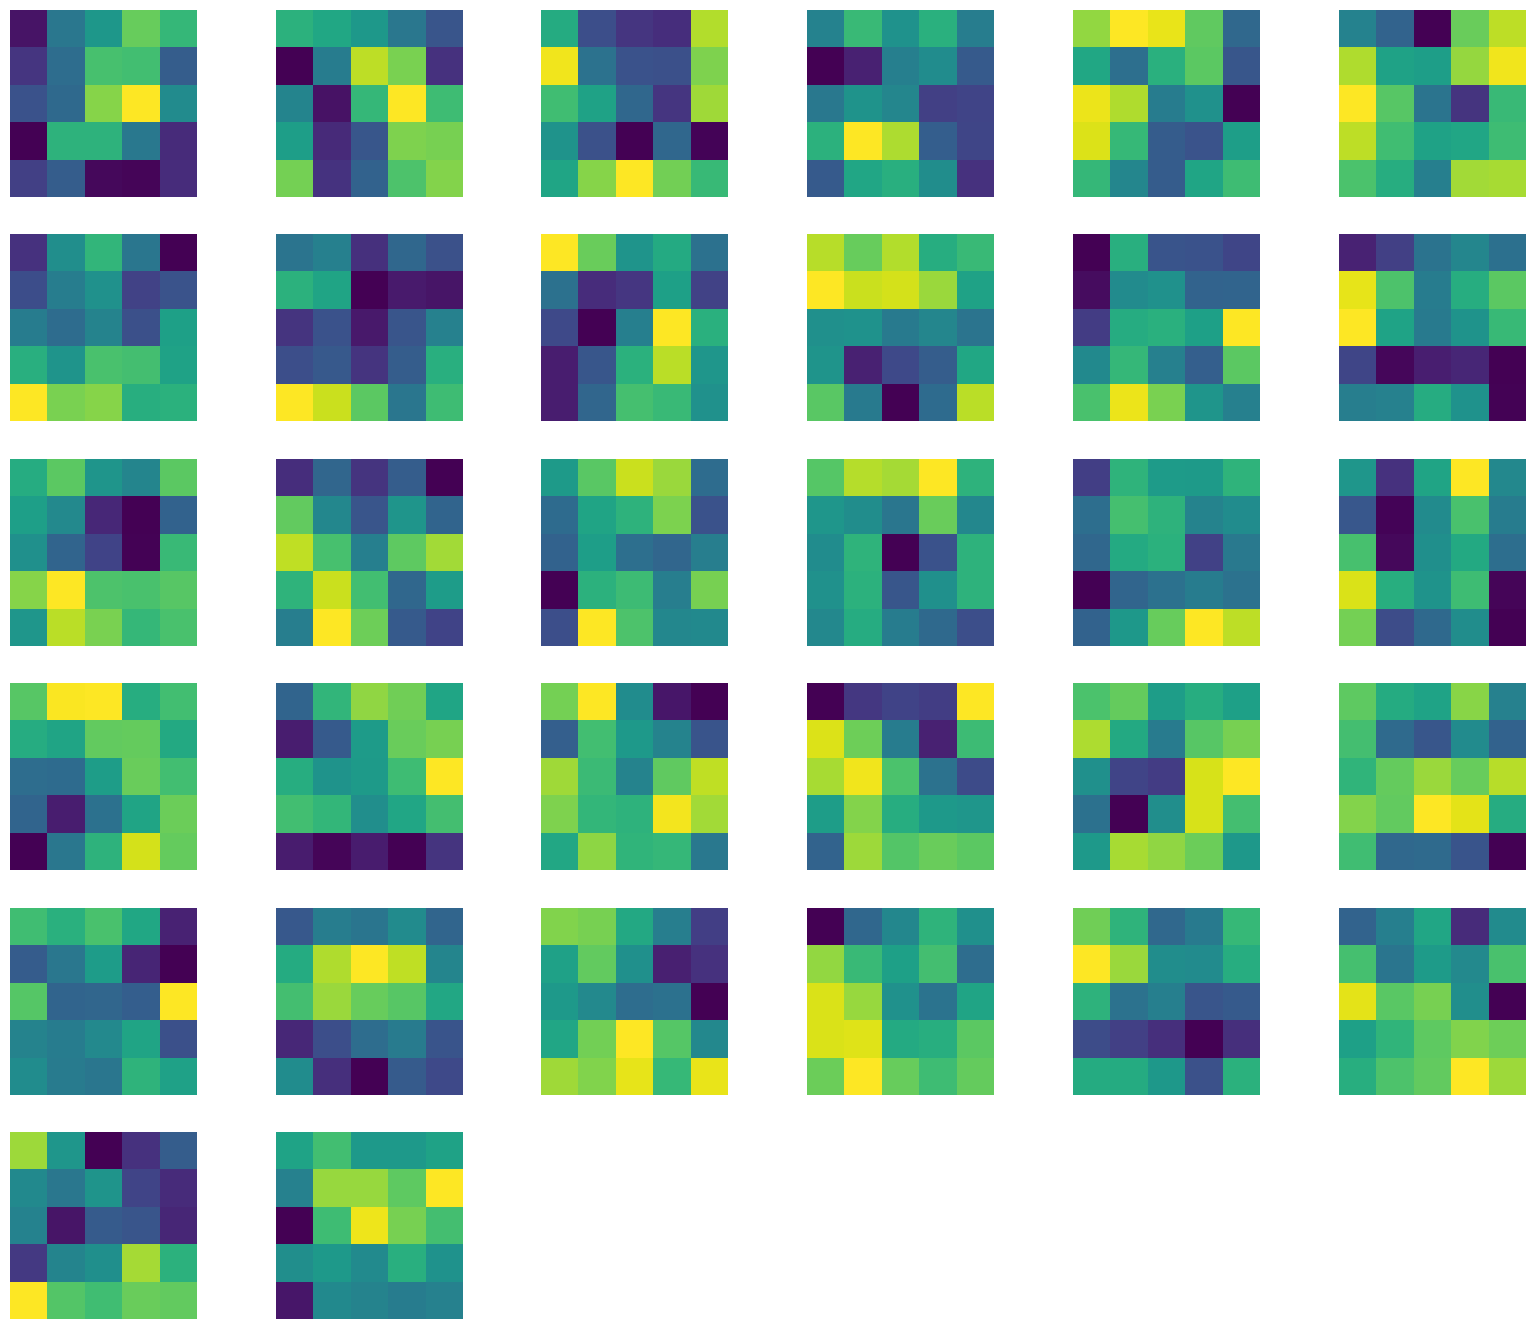

In [9]:
# visualize the second conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(6, 6, i+1) # (8, 8) because in conv0 we have 5x5 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter2.png')
plt.show()

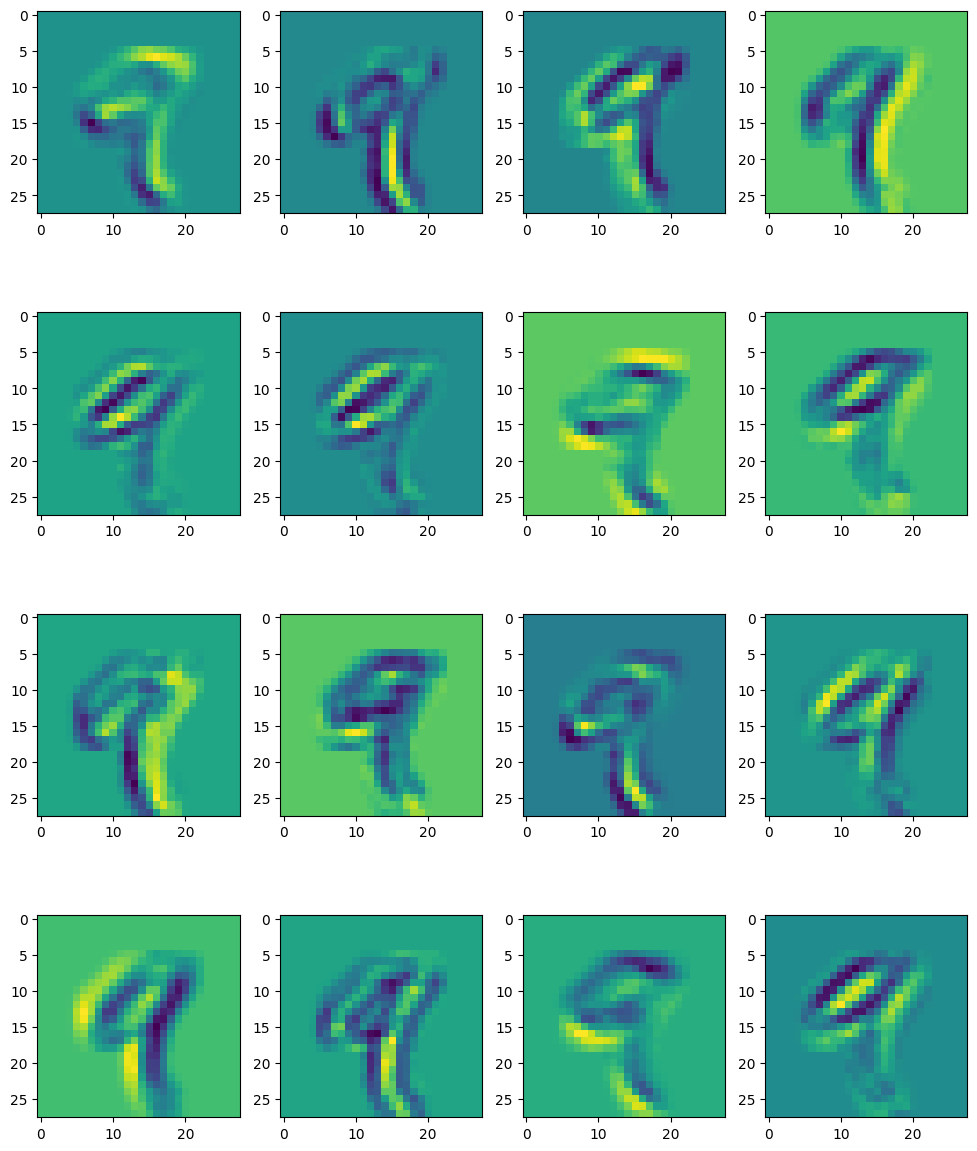

In [10]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = train_dataset[4]
data=data.to(device)
data.unsqueeze_(0)
output = model(data)

k=0
act = activation['conv1'].squeeze()
fig,ax = plt.subplots(4,4,figsize=(12, 15))

for i in range(act.size(0)//4):
        for j in range(act.size(0)//4):
           ax[i,j].imshow(act[k].detach().cpu().numpy())
           k+=1    
           plt.savefig('fm1.png') 

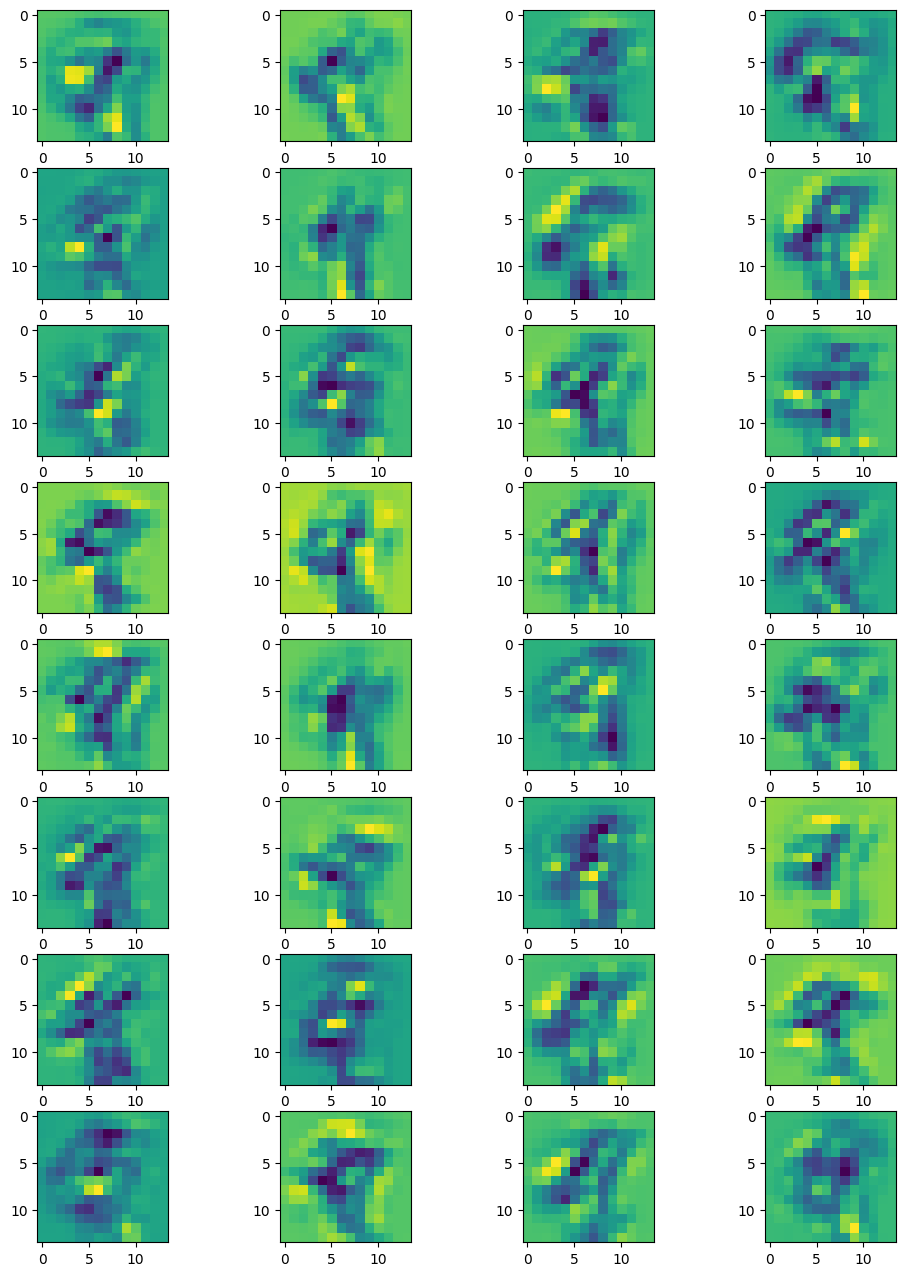

In [11]:
model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = train_dataset[4]
data=data.to(device)
data.unsqueeze_(0)
output = model(data)
act = activation['conv2'].squeeze()

fig, axarr = plt.subplots(act.size(0)//4,4,figsize=(12, 16))
k=0
for i in range(act.size(0)//4):
        for j in range(4):
          axarr[i,j].imshow(act[k].detach().cpu().numpy())
          k+=1  
          plt.savefig('fm2.png')

In [12]:
from scipy import ndimage
import cv2
import math
from PIL import Image

In [13]:
def getBestShift(img):
    cy,cx = ndimage.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [14]:
categ = [0,1,2,3,4,5,6,7,8,9]
# categ = ['a','b','c','d','e','f','g','h']   
categ = [str(i) for i in categ]  
pred = []

# Load the PyTorch model
model = ConvNet()

# Load the trained weights
model.load_state_dict(torch.load('model_weights.pth'))

# Set model to evaluation mode
model.eval()

for cat in categ:
    print('Validate', cat)
    gray = cv2.imread('coba_' + cat + '.png', 0)
    # rescale it
    gray = cv2.resize(255-gray, (2048, 2048))
    # better black and white version
    (thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    while np.sum(gray[0]) == 0:
        gray = gray[1:]
        
    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray, 0, 1)
        
    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]
        
    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)
        
    rows,cols = gray.shape

    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        # first cols then rows
        gray = cv2.resize(gray, (cols,rows))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        # first cols then rows
        gray = cv2.resize(gray, (cols, rows))
        
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray, (rowsPadding,colsPadding), 'constant')

    shiftx, shifty = getBestShift(gray)
    shifted = shift(gray, shiftx, shifty)
    gray = shifted

    # save the processed image
    cv2.imwrite('image_' + cat + '.png', gray)

    img = Image.open('image_'+ cat +'.png').convert('L')
    img = np.resize(img, (28,28,1))
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1, 1, 28, 28)

    # Convert the input image to a PyTorch tensor
    inputs = torch.from_numpy(im2arr).float()

    # Forward pass through the model
    outputs = model(inputs)

    # Get the predicted class
    _, predicted = torch.max(outputs.data, 1)

    # Append the predicted class to the list
    pred.append(predicted.item())

print(pred)
pred = [str(int(i)) for i in pred]
print('\n------')
print('Expected')
print('------')
for i in range(len(categ)):
    print(categ[i], end= ' ')
print('\nPredicted')
print('------')
acc = 0
count = 0
for i in range(len(pred)):
    if pred[i] == categ[i]:
        count += 1
acc = (count/len(categ))*100
for i in range(len(pred)):
    print(pred[i], end=' ')
print('\nAccuracy: %.2f' %acc + '%')


Validate 0


d:\F\Python\Python310\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Validate 1
Validate 2
Validate 3
Validate 4
Validate 5
Validate 6
Validate 7
Validate 8
Validate 9
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

------
Expected
------
0 1 2 3 4 5 6 7 8 9 
Predicted
------
0 1 2 3 4 5 6 7 8 9 
Accuracy: 100.00%
